In [14]:
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 1

First, a bit of setting up:

In [15]:
import itertools
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter # Gaussian kernel convolution

import serpentine as sp # Our library

In [ ]:
# Some eyecandy

from matplotlib import colors as cols
colors = [
    (120. / 350 / 2, 180. / 350 / 2, 230. / 350 / 2),
    (179. / 255, 205. / 255, 227. / 255),
    (1, 1, 1),
    (251. / 255, 180. / 255, 174. / 255),
    (248. / 350 / 2, 120. / 350 / 2, 109. / 350 / 2),
]
cmap_name = "pastelpentine"
cm = cols.LinearSegmentedColormap.from_list(cmap_name, colors, N=21)

Then, let's load the data: 

In [ ]:
# Whole genome matrices

A_raw = np.load('demos/A.npy')
B_raw = np.load('demos/A.npy')

# Cohesin peaks

peaks = np.loadtxt('demos/peaks.csv')

# Chromosome coordinates

slices = (slice(6, 88), # I
          slice(98, 416), # II
          slice(422, 558), # III
          slice(565, 1154), # IV
          slice(1162, 1388), # V
          slice(1395, 1508), # VI
          slice(1513, 1936), # VII
          slice(1947, 2154), # VIII
          slice(2162, 2333), # IX
          slice(2351, 2630), # X
          slice(2646, 2914), # XI
          slice(2925, 3325), # XII (right arm is slice(3107, 3325))
          slice(3343, 3706), # XIII
          slice(3716, 4028), # XIV
          slice(4032, 4443), # XV
         slice(4465, 4819)) # XVI

# Remove useless diagonal signal
A_raw -= np.diag(np.diag(A_raw))
B_raw -= np.diag(np.diag(B_raw))

Let's see what the matrices look like:

In [ ]:
# Visualize the matrices

# First matrix
plt.figure()
sp.mshow(A_raw)
plt.gca().set_axis_off()

# Second matrix
plt.figure()
sp.mshow(B_raw)
plt.gca().set_axis_off()
plt.show()

Focus on chromosome V:

In [ ]:
# Focus on a single chromosome

reg = slices[4] # V

A = A_raw[reg,reg]
B = B_raw[reg,reg]

# First matrix
plt.figure()
sp.mshow(A)
plt.gca().set_axis_off()

# Second matrix
plt.figure()
sp.mshow(B)
plt.gca().set_axis_off()
plt.show()


The raw log-ratio (and corresponding MD-plot) looks like this:

<IPython.core.display.Javascript object>


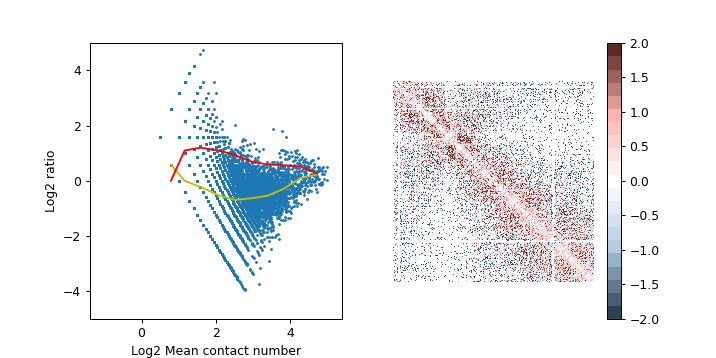

0.3507322421489545


In [17]:
# Raw log-ratio

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
np.warnings.filterwarnings('ignore');
D = np.log2(B/A)
print(len(D[np.isinf(D)])/(len(D)**2))
trend, threshold = sp.MDbefore(A, B, ylim=[-5, 5], xlim=[-1.4,5.4])
plt.subplot(1, 2, 2)
plt.gca().set_axis_off()
plt.margins(0, 0)
sp.dshow(-D, -np.nanmean(D[np.abs(D)!=np.inf]), limit=2)

Then, let's see what happens when we try to bin naively. First, define an appropriate binning function:

In [18]:
def bin_dense(M, subsampling_factor=3):
    """Contact map binning
    
    Sum over each block of given subsampling factor, returns a matrix whose
    dimensions are this much as small (e.g. a 27x27 matrix binned with a
    subsampling factor equal to 3 will return a 9x9 matrix whose each component
    is the sum of the corresponding 3x3 block in the original matrix).
    Remaining columns and rows are summed likewise and added to the end of the
    new matrix.

    Note
    ----
    Will not work for numpy verisons below 1.7
    """

    m = min(M.shape)
    n = (m // subsampling_factor) * subsampling_factor

    if n == 0:
        return np.array([M.sum()])

    N = np.array(M[:n, :n], dtype=np.float64)
    N = N.reshape(
        n // subsampling_factor,
        subsampling_factor,
        n // subsampling_factor,
        subsampling_factor,
    ).sum(axis=(1, 3))
    if m > n:
        remaining_row = M[n:, :n]
        remaining_col = M[:n, n:]
        remaining_square = M[n:m, n:m]
        R = remaining_row.reshape(
            m % subsampling_factor, m // subsampling_factor, subsampling_factor
        ).sum(axis=(0, 2))
        C = (
            remaining_col.T.reshape(
                m % subsampling_factor,
                m // subsampling_factor,
                subsampling_factor,
            )
            .sum(axis=(0, 2))
            .T
        )
        S = remaining_square.sum()
        N = np.append(N, [R], axis=0)
        result = np.append(N, np.array([list(C) + [S]]).T, axis=1)
    else:
        result = N

    return result

Then, perform the binning proper:

In [32]:
subs_factor = 3 # subsampling_factor can be 3 with no issues since the original shape is 216, i.e. a proper multiple

A_binned = bin_dense(A, subsampling_factor=subs_factor)
B_binned = bin_dense(B, subsampling_factor=subs_factor)

A_binned_final = np.zeros(A.shape)
B_binned_final = np.zeros(A.shape)
n, m = A.shape

#Extrapolation takes place here
for i, j in itertools.product(range(0, n, subs_factor), range(0, n, subs_factor)):
    A_binned_final[i:i+subs_factor, j:j+subs_factor] = A_binned[i//subs_factor, j//subs_factor] / (subs_factor)**2
    B_binned_final[i:i+subs_factor, j:j+subs_factor] = B_binned[i//subs_factor, j//subs_factor] / (subs_factor)**2

The resulting log-ratio (and corresponding MD-plot) looks like this:

<IPython.core.display.Javascript object>


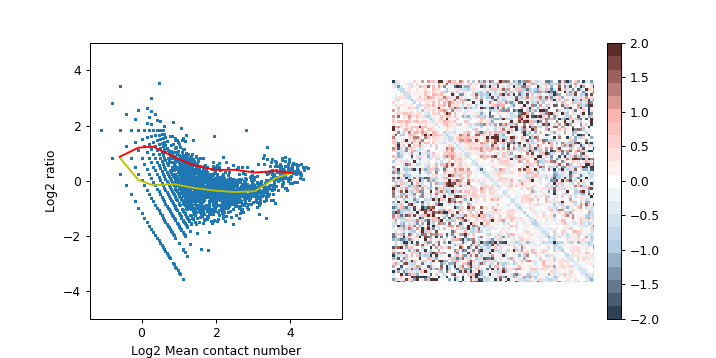

0.04927950505129611


In [8]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
np.warnings.filterwarnings('ignore');
D_binned_final = np.log2(B_binned_final/A_binned_final)
# print(len(D_binned_final[np.isinf(D_binned_final)])/(len(D_binned_final)**2))
new_trend, new_threshold = sp.MDafter(A_binned_final, B_binned_final, D_binned_final, ylim=[-5, 5], xlim=[-1.4,5.4])
plt.subplot(1, 2, 2)
plt.gca().set_axis_off()
plt.margins(0, 0)
sp.dshow(-D_binned_final, -np.nanmean(D_binned_final[np.abs(D_binned_final)!=np.inf]), limit=2)

Then, let's compare with a convolution with a Gaussian kernel:

<IPython.core.display.Javascript object>


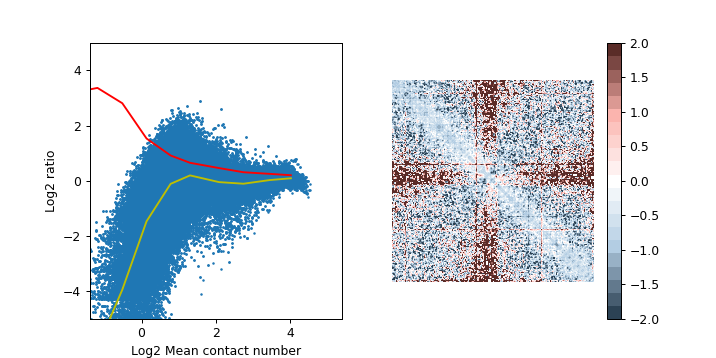

In [33]:
A_gaussian = gaussian_filter(A, sigma=1)
B_gaussian = gaussian_filter(B, sigma=1)

ratio = np.zeros(A.shape)
ratio[A!=0] = B[A!=0] / A[A!=0]
K_gaussian = np.log2(gaussian_filter(ratio, sigma=1))
K_gaussian[np.isnan(K_gaussian)] = 0
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
new_trend, new_threshold = sp.MDafter(A_gaussian, B_gaussian, K_gaussian, ylim=[-5, 5], xlim=[-1.4,5.4])
plt.subplot(1, 2, 2)
plt.gca().set_axis_off()
plt.margins(0, 0)
sp.dshow(-K_gaussian, -np.nanmean(K_gaussian[np.abs(K_gaussian)!=np.inf]), limit=2)

Now, let's perform the serpentine binning proper:

In [20]:
sA, sB, sK = sp.serpentin_binning(A, B, threshold=60, minthreshold=20, verbose=False)

<IPython.core.display.Javascript object>


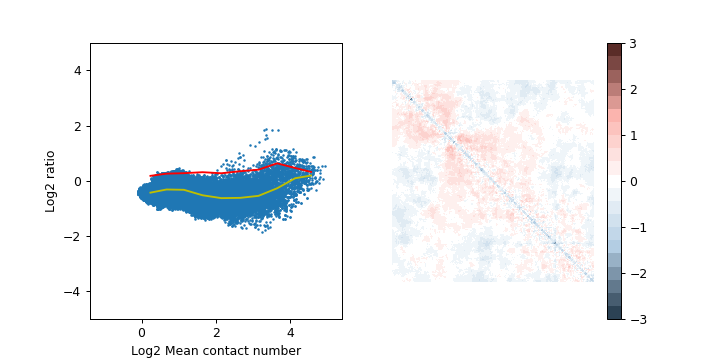

0.0


In [12]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
sp.MDafter(sA, sB, sK, xlim=[-1.4,5.4], ylim=[-5,5])
np.warnings.filterwarnings('ignore');
plt.subplot(1, 2, 2)
plt.gca().set_axis_off()
plt.margins(0, 0)
sp.dshow(-sK, -np.nanmean(sK[np.abs(sK)!=np.inf]), limit=3)

Now we will focus on the effects of down-sampling. First, let's switch chromosomes:

In [24]:
reg = slices[6] # VI

A = A_raw[reg,reg]
B = B_raw[reg,reg]

<IPython.core.display.Javascript object>


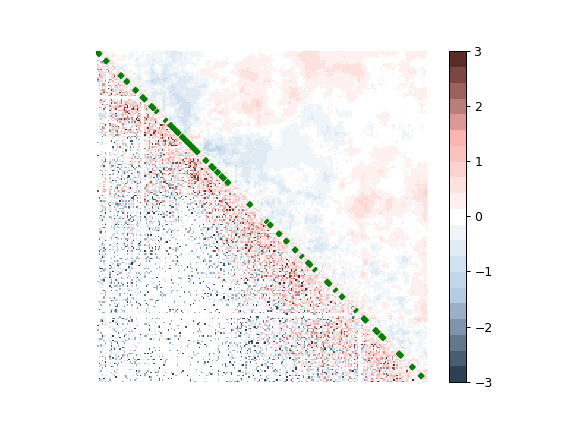

-2.013772612891374


In [25]:
plt.figure()
#plt.subplot(1, 2, 1)
#new_trend, new_threshold = sp.MDafter(sA, sB, sK, ylim=[-4, 4])
#plt.subplot(1, 2, 2)
plt.gca().set_axis_off()
plt.margins(0, 0)
print(new_trend)
sp.dshow(sK - np.tril(sK - np.average(sK)) - np.tril(D - np.nanmean(D[np.abs(D)!=np.inf])), np.average(sK), limit=3)

#peaks = peaks[reg]

#...
csi = 0.5
cle = 1
from matplotlib import patches as pt;
for i in np.nditer(np.where(peaks)):
    i = i - 1
    #plt.axvline(x=i-.5, alpha=0.7, linewidth=.5)
    #plt.axhline(y=i-.5, alpha=0.7, linewidth=.5)
    #plt.arrow(i - 5, i, 5, 0)
    #plt.arrow(i, i+5, 0, -5)
    
    plt.gca().add_patch(pt.Polygon(np.array([[i-cle-csi,i+cle-csi],[i+cle-csi,i-cle-csi],[i+cle+csi,i-cle+csi],[i-cle+csi,i+cle+csi]]), closed=True, color='green'))


In [23]:
reg = slices[6] # VII

A = A_raw[reg,reg]
B = B_raw[reg,reg]

In [27]:
def subsample_contacts(M, prop):
    """
    Bootstrap sampling of contacts in a sparse Hi-C map.
    Parameters
    ----------
    M : scipy.sparse.csr_matrix
        The input Hi-C contact map in sparse format.
    prop : float
        The proportion of contacts to sample.
    Returns
    -------
    scipy.sparse.csr_matrix
        A new matrix with a fraction of the original contacts.
    """
    # NOTE: RAM usage vs speed could be balanced by flushing
    # dictionary and recomputing cumsum a given number of times.

    if prop > 1 or prop < 0:
        raise ValueError(
            "The proportion of contacts to sample must be between 0 and 1."
        )
    # Only work with non-zero data of matrices
    O = csr_matrix(M).data
    S = O.copy()
    # Match cell idx to cumulative number of contacts
    cum_sum = np.cumsum(O)
    # Total number of contacts to remove
    tot_contacts = int(max(cum_sum))
    n_remove = int((1 - prop) * tot_contacts)
    # Store contacts that have already been removed
    removed = {}

    for _ in range(n_remove):
        to_remove = np.random.randint(tot_contacts)
        while to_remove in removed:
            to_remove = np.random.randint(tot_contacts)
        # Find idx of cell to deplete and deplete it
        removed[to_remove] = np.searchsorted(cum_sum, to_remove)
        S[removed[to_remove]] -= 1

    return csr_matrix((S, (M.row, M.col)), shape=(M.shape[0], M.shape[1]))

In [ ]:
threshold=40
for k, my_slice in enumerate(slices):
    Ad = A[my_slice, my_slice]
    Bd = B[my_slice, my_slice]
    Dd = np.log2(Bd/Ad)
    peaks = my_peaks[my_slice]
    sA, sB, sK = sp.serpentin_binning(Bd, Ad, threshold, 10,
iterations=64, parallel=16, verbose=False, triangular=False)
    trend = np.mean(sK[~(np.isnan(sK) + np.isinf(sK))]);
    plt.figure()
    if np.isnan(sK).any() or np.isinf(sK).any():
        raise ValueError("Found nans or infs")
    plt.imshow((sK - np.tril(sK - np.average(sK)) - np.tril(Dd - np.nanmean(Dd[np.abs(Dd)!=np.inf]))-trend), vmin=-3, vmax=3, cmap=cm,
interpolation="none")

    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0,
wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    csi = 0.5
    cle = 1
    from matplotlib import patches as pt;
    for i in np.nditer(np.where(peaks)):
        i = i - 1
        #plt.axvline(x=i-.5, alpha=0.7, linewidth=.5)
        #plt.axhline(y=i-.5, alpha=0.7, linewidth=.5)
        #plt.arrow(i - 5, i, 5, 0)
        #plt.arrow(i, i+5, 0, -5)

        plt.gca().add_patch(pt.Polygon(np.array([[i-cle-csi,i+cle-csi],[i+cle-csi,i-cle-csi],[i+cle+csi,i-cle+csi],[i-cle+csi,i+cle+csi]]), closed=True, color='green'))

In [ ]:
import datetime

import time
times = []

n_cycles = 10
for i in range(9):
    Ar = np.array(np.random.rand(2**i, 2**i)*100, dtype=np.int32)
    Br = np.array(np.random.rand(2**i, 2**i)*100, dtype=np.int32)
    init_start = datetime.datetime.now()
    for _ in range(n_cycles):
        sp.serpentin_binning(Ar, Br, threshold=60, minthreshold=20, verbose=False, parallel=1)
    ten_cycles_time = datetime.datetime.now() - init_start
    times.append(ten_cycles_time.total_seconds() / n_cycles)
    init_start = datetime.datetime.now()
    
x, y = zip(*enumerate(times))
plt.scatter(x=2**np.array(x), y=y)
plt.plot(2**np.array(x[3:]), y[3:])
plt.xscale("log")
plt.yscale("log")
plt.show()